<a href="https://colab.research.google.com/github/qraxiss/learning-data-science/blob/main/tarim_siniflandirma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ycimpute

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from warnings import filterwarnings
from ycimpute.imputer import knnimput
from sklearn.neighbors import LocalOutlierFactor


filterwarnings('ignore')

In [ ]:
pd.read_csv("drive/MyDrive/Data/mahalle.csv")

,ILCE,MAHALLE,MAH_CD_SK_SAYISI,ILCE_CDSK_SAYI,YAPI,EK_BINA,GECICI,INSAAT,ISYERI_SAYISI,KAMU_ISYERI,KONUT,NUFUS,OZEL_ISYERI,YAZLIK_MEVSIMLIK
0,AHIRLI,AKKISE,21,289,177,0,0,6,4,2,185,518,8,1
1,AHIRLI,ALICERCI,16,289,130,0,0,2,NaN,2,136,106,1,0
2,AHIRLI,BADEMLI,21,289,252,0,0,0,3,4,266,313,5,2
3,AHIRLI,BALIKLAVA,18,289,133,0,0,3,NaN,3,137,186,2,9
4,AHIRLI,BUYUKOZ,9,289,55,0,1,0,NaN,1,57,47,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,YUNAK,YAVASLI,27,"1,276",122,0,0,7,3,6,123,257,7,0
1155,YUNAK,YENI,81,"1,276",750,0,0,22,512,67,988,"1,934",491,0
1156,YUNAK,YESILOBA,16,"1,276",66,0,0,1,7,4,66,96,14,0
1157,YUNAK,YESILYAYLA,13,"1,276",91,0,0,0,1,4,92,106,1,0


In [ ]:
# Import
mahalle = pd.read_csv("drive/MyDrive/Data/mahalle.csv")
mahalle = mahalle[mahalle.columns[[0,1,12,11,9]]]
mahalle.index = mahalle["ILCE"] + "+" + mahalle["MAHALLE"]
mahalle.index.name = "Konum"
ilce = mahalle["ILCE"]
mahalle = mahalle[mahalle.columns[2:]]

# Str to int
mahalle = mahalle.fillna(-1)
for column in mahalle.columns:
  for item, index in zip(mahalle[column], np.arange(len(mahalle))):
    if item != -1:
      mahalle[column].iloc[index] = int(str(item).replace(",",""))
    elif item == -1:
      mahalle[column].iloc[index] = np.nan

# Yuz Olcumu Ekle
yuz_olcumu = pd.read_csv("drive/MyDrive/Tarım/Mahalle_Ilce_Yuz.csv")
yuz_olcumu.index = yuz_olcumu["Ilce"] + "+" + yuz_olcumu["Mahalle"]
yuz_olcumu = (yuz_olcumu["YuzOlcumu"]/1000).apply(int)
yuz_olcumu.columns = ["ALAN"]
mahalle["ALAN"] = yuz_olcumu

# Tarım Katsayılarını Ekle
df = pd.read_csv("drive/MyDrive/Tarım/katsayi.csv")
df.index = df[df.columns[0]]
df = df[df.columns[3:]]
df.index.name = "Konum"
df["SU"] = df["SULAK URUN"]**2/df["SULAK ALAN"]**1/2
df["TORPAK"] = df["NORMAL URUN"]**2/df["ELVERISLI ALAN"]**1/2
mahalle[["SU", "TORPAK"]]=df[["SU", "TORPAK"]]

# Durakları Ekle
durak = pd.read_csv("drive/MyDrive/durak_konum_final.csv").groupby("Konum").sum()
index = durak.index
new_index = list()
ilceler = list()
for konum,i in zip(index, np.arange(len(index))):
  konum_index = konum.index(" ")
  item = (index[i][:konum_index] + "+" + index[i][konum_index+1:]).replace("İ","I").replace("Ş","S").replace("Ç","C").replace("Ö","O").replace("Ğ","G").replace("Ü","U")
  new_index.append(item)
durak.index = new_index
mahalle["DURAK"] = durak
mahalle["DURAK"] = mahalle["DURAK"].fillna(0)
mahalle["DURAK"] = mahalle["DURAK"] + 1

# # Ilceleri Kategorik Degisken Olarak Ekleme
# ilceler=set(ilce)
# ilce_dummies = pd.DataFrame(columns=ilceler, index=mahalle.index).fillna(0)
# ilce_dummies
# ilceler = list(ilce_dummies.columns)
# for konum,index in zip(ilce_dummies.index, np.arange(len(df))):
#   strindex = konum.index("+")
#   ilce_index = ilceler.index(konum[:strindex])
#   ilce_dummies[ilceler[ilce_index]].iloc[index] = 1

# Yoğunluk
mahalle["YOĞUNLUK"] = mahalle["NUFUS"]/mahalle["ALAN"]

# Günlük Göç
mahalle["GÜNLÜK GÖÇ"] = mahalle["DURAK"] * mahalle["OZEL_ISYERI"] 

# Konum Ekle
xy = pd.read_csv("drive/MyDrive/mahalle_kume.csv")
xy.index = xy["Unnamed: 0"]
xy.drop("Unnamed: 0", axis=1, inplace=True)
mahalle[xy.columns] = xy

# Fill Na
mahalle.drop(["OZEL_ISYERI", "NUFUS", "ALAN", "DURAK", "KAMU_ISYERI"], axis=1, inplace=True)
# mahalle[ilce_dummies.columns] = ilce_dummies
var_names = list(mahalle)
n_df = np.array(mahalle)
df = knnimput.KNN(k = 4).complete(n_df)
df = pd.DataFrame(df, columns = var_names, index = mahalle.index)

df.head()

Imputing row 1/1159 with 0 missing, elapsed time: 0.306
Imputing row 101/1159 with 0 missing, elapsed time: 0.308
Imputing row 201/1159 with 0 missing, elapsed time: 0.309
Imputing row 301/1159 with 0 missing, elapsed time: 0.310
Imputing row 401/1159 with 0 missing, elapsed time: 0.311
Imputing row 501/1159 with 0 missing, elapsed time: 0.312
Imputing row 601/1159 with 0 missing, elapsed time: 0.313
Imputing row 701/1159 with 0 missing, elapsed time: 0.314
Imputing row 801/1159 with 0 missing, elapsed time: 0.315
Imputing row 901/1159 with 0 missing, elapsed time: 0.316
Imputing row 1001/1159 with 0 missing, elapsed time: 0.317
Imputing row 1101/1159 with 0 missing, elapsed time: 0.318


,SU,TORPAK,YOĞUNLUK,GÜNLÜK GÖÇ,x,y,kume_no
Konum,,,,,,,
AHIRLI+AKKISE,0.5,0.500000,0.128504,8.0,32.141403,37.383187,2.0
AHIRLI+ALICERCI,12.5,0.500000,0.016196,1.0,32.150094,37.257404,2.0
AHIRLI+BADEMLI,8.0,0.166667,0.015676,5.0,32.173200,37.290989,2.0
AHIRLI+BALIKLAVA,2.0,3.125000,0.008370,2.0,32.186344,37.326142,2.0
AHIRLI+BUYUKOZ,2.0,2.000000,0.019624,0.0,32.154913,37.272751,2.0


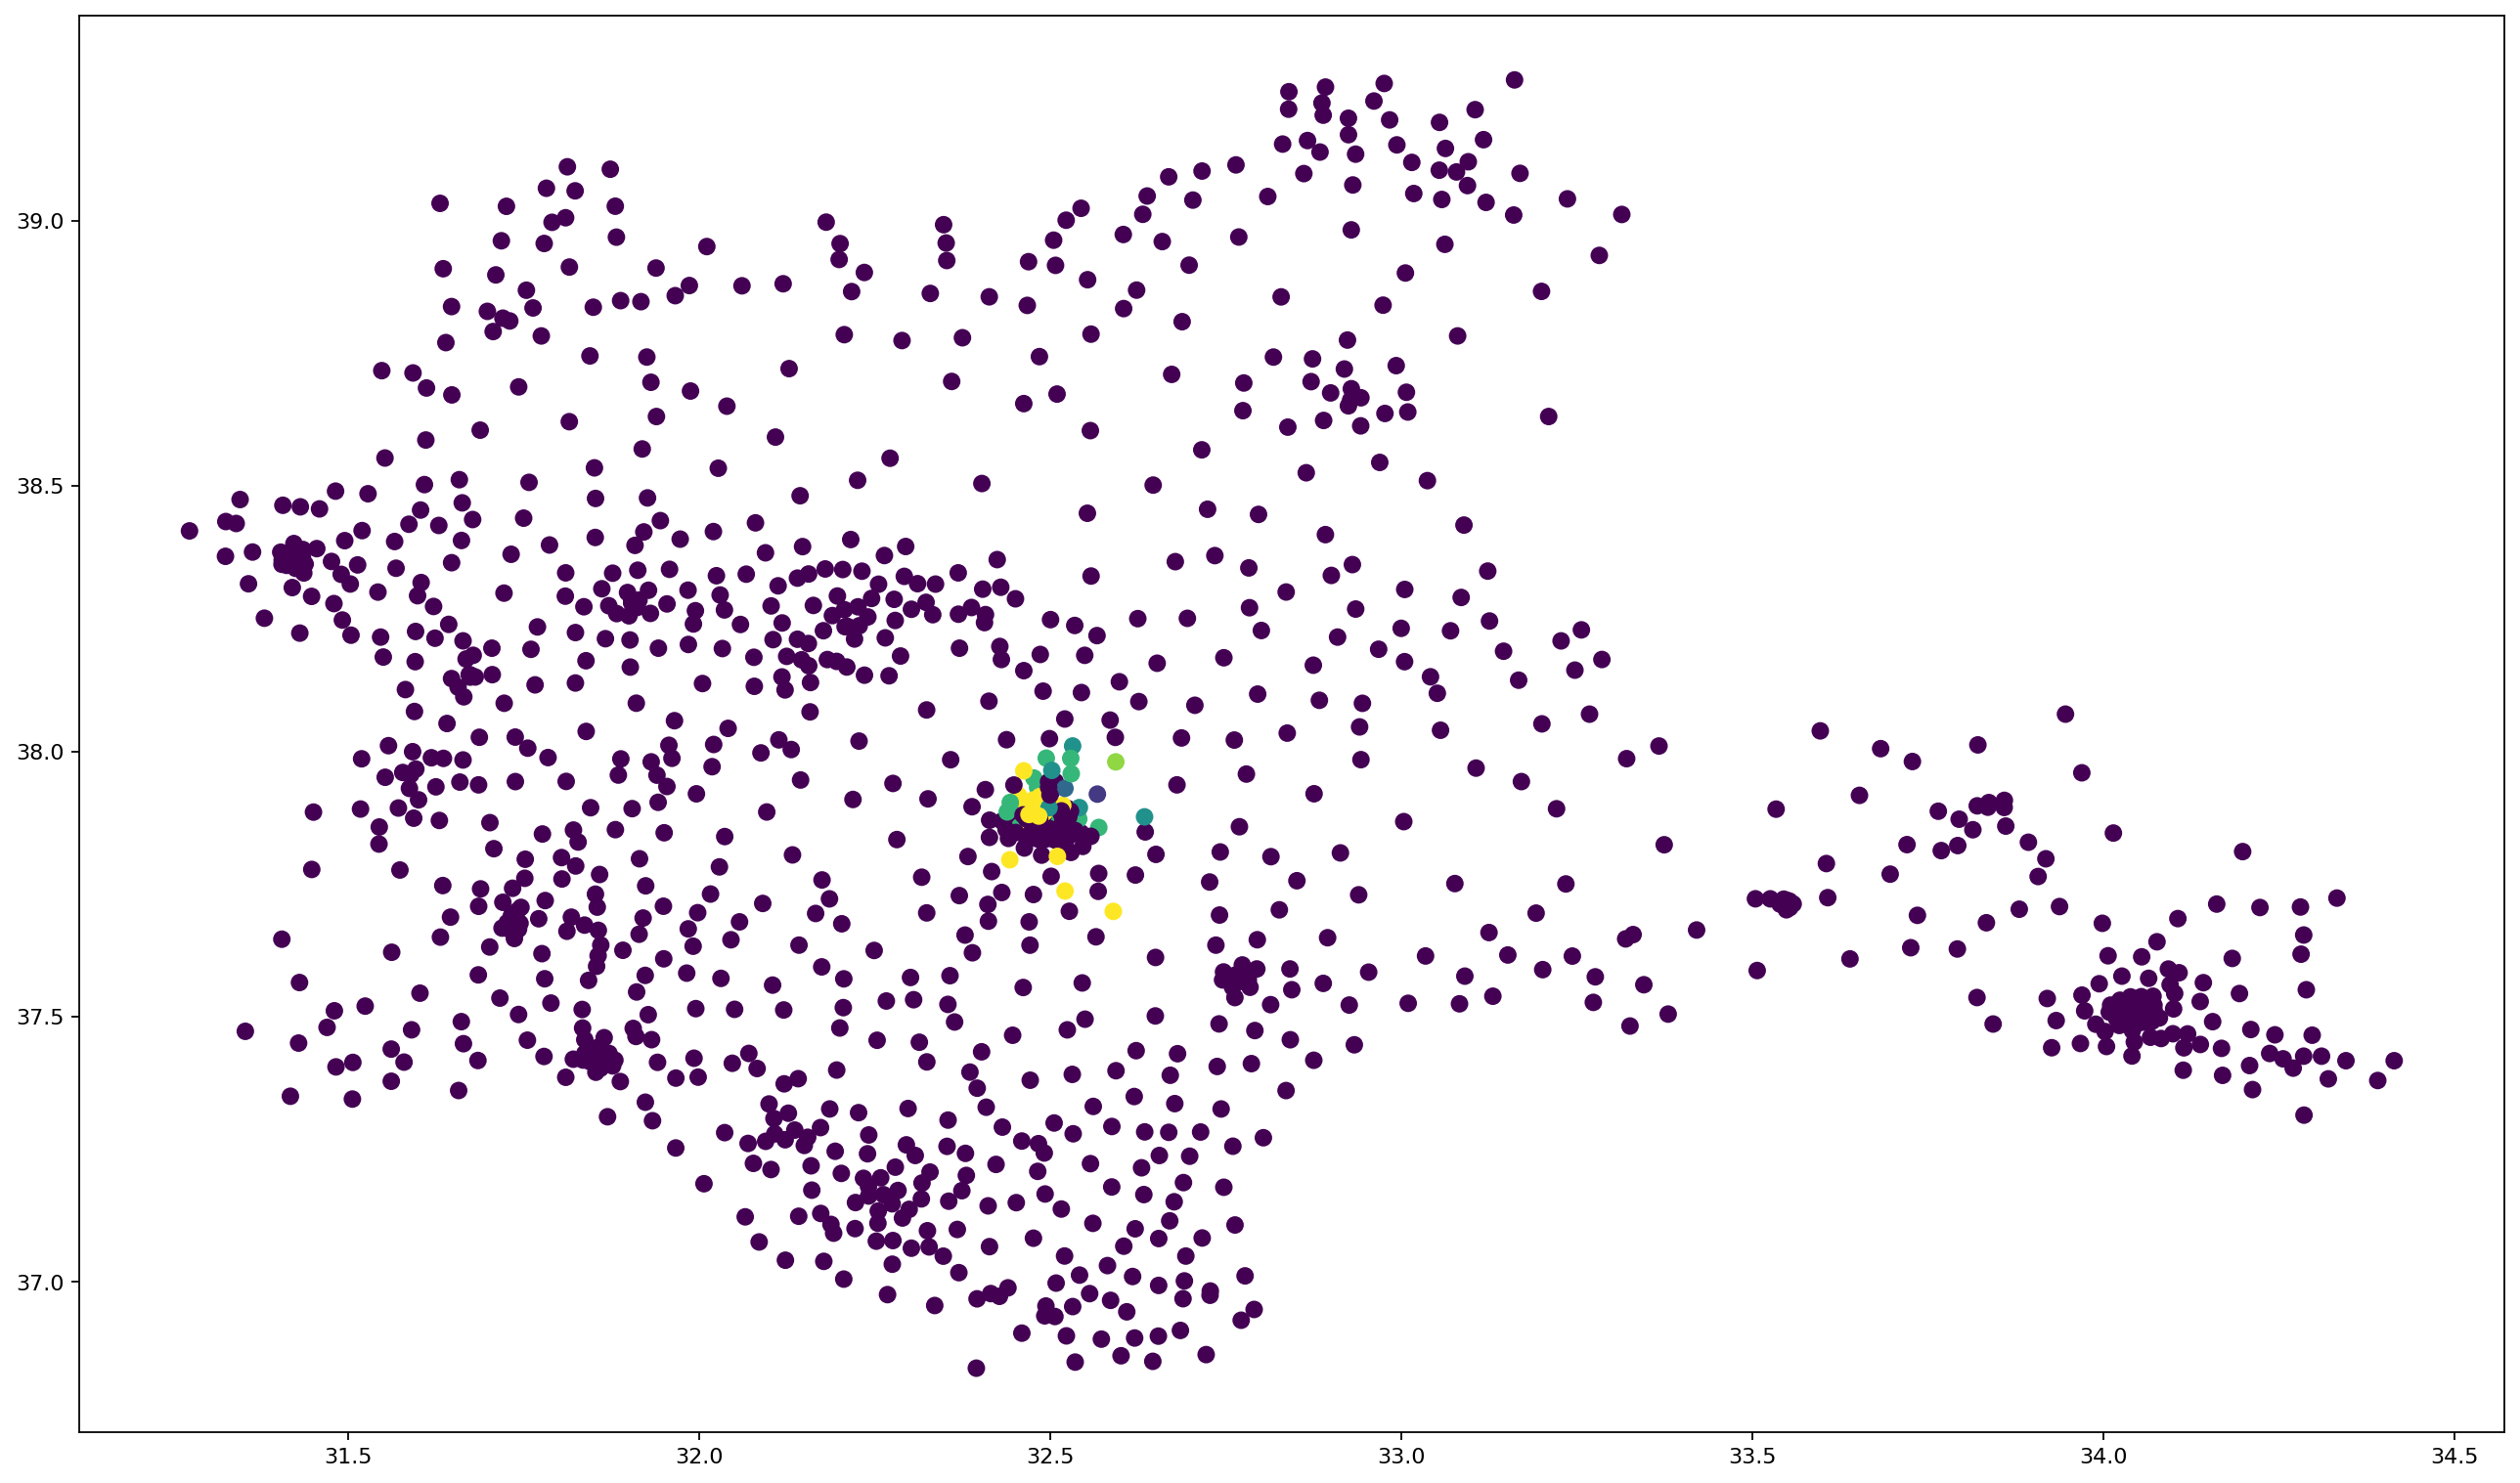

In [ ]:
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure

#kumeler ve gözlem birimleri
kmeans = KMeans(n_clusters = 7)
k_fit = kmeans.fit(df.drop(["kume_no","SU","TORPAK"], axis=1))
kumeler = k_fit.labels_
pd.DataFrame({"Eyaletler" : df.index, "Kumeler": kumeler})[0:10]
df["kume_no2"] = kumeler
df["kume_no2"] = df["kume_no2"] + 1
figure(figsize=(20, 12), dpi=160)
# kmeans = KMeans(n_clusters = 4)
# k_fit = kmeans.fit(df)
kumeler = k_fit.labels_
plt.scatter(df.iloc[:,4], df.iloc[:,5], c = kumeler, s = 50, cmap = "viridis");

In [ ]:
df

,SU,TORPAK,YOĞUNLUK,GÜNLÜK GÖÇ,x,y,kume_no,kume_no2
Konum,,,,,,,,
AHIRLI+AKKISE,0.500000,0.500000,0.128504,8.0,32.141403,37.383187,2.0,1
AHIRLI+ALICERCI,12.500000,0.500000,0.016196,1.0,32.150094,37.257404,2.0,1
AHIRLI+BADEMLI,8.000000,0.166667,0.015676,5.0,32.173200,37.290989,2.0,1
AHIRLI+BALIKLAVA,2.000000,3.125000,0.008370,2.0,32.186344,37.326142,2.0,1
AHIRLI+BUYUKOZ,2.000000,2.000000,0.019624,0.0,32.154913,37.272751,2.0,1
...,...,...,...,...,...,...,...,...
YUNAK+YAVASLI,0.431034,0.173077,0.004410,7.0,31.844764,38.745234,1.0,1
YUNAK+YENI,0.500000,0.500000,1.196782,491.0,31.720766,38.816347,1.0,1
YUNAK+YESILOBA,0.403226,0.285714,0.001533,14.0,31.851179,38.534301,1.0,1


[-3.38731217 -3.38731217 -3.38731217 -3.38731217 -2.99803063 -2.98102668
 -2.89889423 -2.72718647 -2.6765982  -2.67148776 -2.64694635 -2.59321038
 -2.37196924 -2.30645264 -2.30283366 -2.28910675 -2.2584141  -2.21742814
 -2.21363713 -2.1802063 ]
     KAMU_ISYERI   SU    TORPAK  DURAK  YOĞUNLUK  GÜNLÜK GÖÇ  TUZLUKCU  ILGIN  \
762         22.0  0.5  0.166667   42.0  1.975782     61320.0       0.0    0.0   
767         22.0  0.5  0.166667   42.0  1.975782     61320.0       0.0    0.0   
972         22.0  0.5  0.166667   42.0  1.975782     61320.0       0.0    0.0   
990         22.0  0.5  0.166667   42.0  1.975782     61320.0       0.0    0.0   

     MERAM  YALIHUYUK  ...  YUNAK  BOZKIR  HADIM  AHIRLI  KULU  AKOREN  \
762    0.0        0.0  ...    0.0     0.0    0.0     0.0   0.0     0.0   
767    0.0        0.0  ...    0.0     0.0    0.0     0.0   0.0     0.0   
972    0.0        0.0  ...    0.0     0.0    0.0     0.0   0.0     0.0   
990    0.0        0.0  ...    0.0     0.0    0.0     

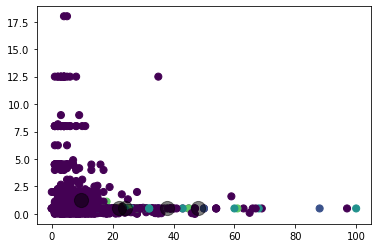

In [ ]:
# Çok Boyutlu Aykırı Gözlem Baskılama
clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
print(np.sort(df_scores)[:20])
esik_deger = np.sort(df_scores)[3]
aykiri_tf = df_scores > esik_deger
baski_deger = df[df_scores == esik_deger]
aykirilar = df[~aykiri_tf]
print(aykirilar)

aykirilar.to_records(index = False)
res = aykirilar.to_records(index = False)
res[:] = baski_deger.to_records(index = False)
df[~aykiri_tf] = pd.DataFrame(res, index = df[~aykiri_tf].index)

gozetimsiz = KMeans(n_clusters=5)
gozetimsiz_fit = gozetimsiz.fit(df)

kumeler = gozetimsiz_fit.labels_
plt.scatter(df.iloc[:,0], df.iloc[:,1], c = kumeler, s = 50, cmap = "viridis")
merkezler = gozetimsiz_fit.cluster_centers_
plt.scatter(merkezler[:,0], merkezler[:,1], c = "black", s = 200, alpha = 0.5);